In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Simulation Parameters
N_SIMULATIONS = 1000000  # Number of packages simulated
BASE_DELIVERY_TIME = 2  # Days under normal conditions

#-----------------------------------------------------------------------------------------

# Weather Parameters
# Wheather delays will be randomly assigned as we don't have a specific data
# Rest of the parameter based on the real data

WIND_PROB = 0.01
WIND_DELAY = np.random.randint(0.5, 1, N_SIMULATIONS)  

RAIN_PROB = 0.05  
RAIN_DELAY = np.random.randint(1, 2, N_SIMULATIONS)  
#maybe rename to strong rain?

SNOW_PROB = 0.17 
SNOW_DELAY = np.random.randint(1, 2, N_SIMULATIONS)  

HIGH_SNOW_PROB = 0.05 
HIGH_SNOW_DELAY = np.random.randint(2, 3, N_SIMULATIONS)  

STORM_DELAY = 4

ICE_PROB = 0.31
ICE_AFTER_SNOW_PROB = 0.4
ICE_DELAY = np.random.randint(1, 2, N_SIMULATIONS)

#-----------------------------------------------------------------------------------------

# Strike Parameter
# Probability and delay are beforehand calculated from real world data.


# Short Strike of lenght of 0 to 3 days
SHORT_STRIKE_PROB = 0.0052
SHORT_STRIKE_DELAY = 1.61

# Long Strike of lenght of more than 3 days
LONG_STRIKE_PROB = 0.0014
LONG_STRIKE_DELAY = 8.6

#-----------------------------------------------------------------------------------------

# Network Congestion Parameter

# Independent Network Congestions
INDEPENDENT_CONGESTION_PROB = 0.12
INDEPENDENT_CONGESTION_DELAY = np.random.randint(1, 3, N_SIMULATIONS)

# Dependent Network Congestions (conditional on specific weather or strike events)
CONGESTION_PROB_WIND = 0.1
CONGESTION_PROB_RAIN = 0.2
CONGESTION_PROB_SNOW = 0.3
CONGESTION_PROB_HIGH_SNOW = 0.5
CONGESTION_PROB_ICE = 0.4
CONGESTION_PROB_SHORT_STRIKE = 0.6
CONGESTION_PROB_LONG_STRIKE = 0.8
DEPENDENT_CONGESTION_DELAY = np.random.randint(1, 4, N_SIMULATIONS)


In [3]:
# Monte Carlo Simulation
def simulate_delivery():
    delays = np.zeros(N_SIMULATIONS)  # Initialize delays array of lenght N_SIMULATIONS filled with zeros

#-----------------------------------------------------------------------------------------

    # Weather Simulation


    # --- Heavy snow and normal snow (mutually exclusive) ---
    # Simulates whether heavy snow occurs for each parcel (True for ~5% if HIGH_SNOW_PROB = 0.05)
    high_snow_occurs = np.random.rand(N_SIMULATIONS) < HIGH_SNOW_PROB
    # Adds heavy snow delay only to parcels where heavy snow occurred
    # (Numpy lets True become 1, so only affected parcels receive a delay from HIGH_SNOW_DELAY array)
    delays += high_snow_occurs * HIGH_SNOW_DELAY


    # --- Normal snow occurs only if heavy snow did not occur ---
    snow_occurs = (np.random.rand(N_SIMULATIONS) < SNOW_PROB) & (~high_snow_occurs)
    delays += snow_occurs * SNOW_DELAY

    #Also necessary to add high_snow_occurs if ~snow_occurs??

    # --- Rain and snow (mutually exclusive approximation) ---
    # Only rain if snow (normal or heavy) did not happen
    rain_occurs = (np.random.rand(N_SIMULATIONS) < RAIN_PROB) & (~snow_occurs) & (~high_snow_occurs)
    delays += rain_occurs * RAIN_DELAY

    # --- Ice: can occur independently, but more likely after heavy snow ---
    base_ice_occurs = np.random.rand(N_SIMULATIONS) < ICE_PROB
    conditional_ice_after_snow = high_snow_occurs & (np.random.rand(N_SIMULATIONS) < ICE_AFTER_SNOW_PROB)
    ice_occurs = base_ice_occurs | conditional_ice_after_snow
    delays += ice_occurs * ICE_DELAY

    # --- Wind (independent) ---
    wind_occurs = np.random.rand(N_SIMULATIONS) < WIND_PROB
    delays += wind_occurs * WIND_DELAY

    # --- Storm event (combined wind + rain or snow) replaces individual delays if occurred ---
    storm_occurs = wind_occurs & (rain_occurs | snow_occurs | high_snow_occurs)
    delays[storm_occurs] -= (wind_occurs * WIND_DELAY + rain_occurs * RAIN_DELAY + snow_occurs * SNOW_DELAY + high_snow_occurs * HIGH_SNOW_DELAY)[storm_occurs]
    delays[storm_occurs] += STORM_DELAY



#-----------------------------------------------------------------------------------------

    #Strike Simulation

    # --- Strikes: only one type of strike can happen at a time ---
    strike_randoms = np.random.rand(N_SIMULATIONS)
    long_strike_occurs = strike_randoms < LONG_STRIKE_PROB
    short_strike_occurs = (strike_randoms < SHORT_STRIKE_PROB) & (~long_strike_occurs)

    delays += long_strike_occurs * LONG_STRIKE_DELAY
    delays += short_strike_occurs * SHORT_STRIKE_DELAY

#-----------------------------------------------------------------------------------------

    #Network Congestion Simulation

    # --- Independent congestion ---
    independent_congestion_occurs = np.random.rand(N_SIMULATIONS) < INDEPENDENT_CONGESTION_PROB
    delays += independent_congestion_occurs * INDEPENDENT_CONGESTION_DELAY

    # --- Dependent congestion (separate probabilities for each event) ---
    dependent_congestion_occurs = (
        (wind_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_WIND)) |
        (rain_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_RAIN)) |
        (snow_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_SNOW)) |
        (high_snow_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_HIGH_SNOW)) |
        (ice_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_ICE)) |
        (short_strike_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_SHORT_STRIKE)) |
        (long_strike_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_LONG_STRIKE))
    )
    delays += dependent_congestion_occurs * DEPENDENT_CONGESTION_DELAY

#-----------------------------------------------------------------------------------------

    # --- Total delivery time ---

# Calculate total delivery time by adding base delivery time to individual delays
# NumPy automatically broadcasts the scalar BASE_DELIVERY_TIME (e.g. 2) to all 1,000,000 parcels
# Then performs element-wise addition: total_delivery_time[i] = BASE_DELIVERY_TIME + delays[i]
total_delivery_time = BASE_DELIVERY_TIME + delays

# Return the array of total delivery times for all simulated parcels
# Each value represents how long a parcel took to be delivered, including any delays
return total_delivery_time


In [4]:
# Run Simulation
delivery_times = simulate_delivery()

In [5]:
# Statistical Analysis
mean_delivery = np.mean(delivery_times)
median_delivery = np.median(delivery_times)
prob_over_5_days = np.mean(delivery_times > 5)
prob_over_10_days = np.mean(delivery_times > 10)

In [6]:
# Display Results
print(f"Mean Delivery Time: {mean_delivery:.2f} days")
print(f"Median Delivery Time: {median_delivery:.2f} days")
print(f"Probability of Delivery > 5 days: {prob_over_5_days:.2%}")
print(f"Probability of Delivery > 10 days: {prob_over_10_days:.2%}")

Mean Delivery Time: 3.20 days
Median Delivery Time: 3.00 days
Probability of Delivery > 5 days: 11.09%
Probability of Delivery > 10 days: 0.15%


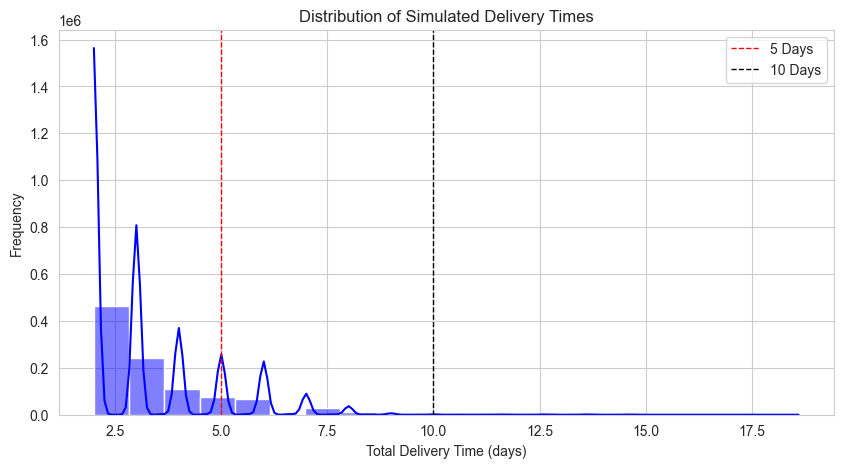

In [7]:
# Visualization
plt.figure(figsize=(10,5))
sns.histplot(delivery_times, bins=20, kde=True, color='blue')
plt.axvline(5, color='red', linestyle='dashed', linewidth=1, label='5 Days')
plt.axvline(10, color='black', linestyle='dashed', linewidth=1, label='10 Days')
plt.xlabel('Total Delivery Time (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Simulated Delivery Times')
plt.legend()
plt.show()